In [658]:
%load_ext autoreload
%autoreload 2




        

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [659]:
import numpy as np
import random
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import gym

np.random.seed(13)
torch.manual_seed(13)

plt.ion()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("The model will be trained with", device)



The model will be trained with cuda


In [660]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("The model will be trained with", device)



The model will be trained with cuda


In [661]:
from environments.SnowmanEnvironment import SnowmanEnvironment
map_path = './Dades/andy.txt'
save_path = './trainedModels/andy.pt'


In [662]:
map_rows=9
map_cols=9
n_actions = 4 #Modifica quan implementi gym


gym.register(
    id='SnowmanEnv-v0',
    entry_point='environments.SnowmanEnvironment:SnowmanEnvironment',
    kwargs = {
        'map_file': map_path, 
        'n': map_rows, 
        'm': map_cols,
        'preprocess_mode': SnowmanEnvironment.NO_PREPROCESS,
        'enable_step_back_optimzation': False, 
        'enable_blocked_snowman_optimization': True,
        'enable_snowball_number_optimization': True,
        'enable_snowball_distances_optimization': False,
        'enable_visited_cells_optimization': False
    })


env = gym.make('SnowmanEnv-v0',  map_file=map_path, 
                                 n=map_rows, m=map_cols,
                                 preprocess_mode=SnowmanEnvironment.NO_PREPROCESS,
                                 enable_step_back_optimzation=False, 
                                 enable_blocked_snowman_optimization=True,
                                 enable_snowball_number_optimization=True,
                                 enable_snowball_distances_optimization=False,
                                 enable_visited_cells_optimization=False)

n,m:  9 9
setting agent position to  4 4


In [663]:
debug_mode = False

MAIN TRAINING LOOP

In [664]:
episodes=220000
jugades=60
rewards = []
rewards_per_jugada = []
best_score = -100000

In [665]:
seed = 13
gae_lambda = 0.95
gamma = 0.99
learning_rate = 1E-4
batch_size = 0
update_epochs = 4
num_minibatches = 8
minibatch_size =  int(batch_size // num_minibatches)
clip_coef = 0.2
norm_adv = False
clip_vloss = True
num_envs = 4
num_steps=  60
total_timesteps = 500000

ent_coef = 0.01
vf_coef= 0.5
max_grad_norm= 0.5
target_kl=  None

env_id = 'SnowmanEnv-v0'

In [666]:
import os
import random
import time
from dataclasses import dataclass

import gym as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical
from torch.utils.tensorboard import SummaryWriter

def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer



In [667]:
def make_env(env_id):
    def thunk():
        env = gym.make(env_id)
        env = gym.wrappers.RecordEpisodeStatistics(env)
        return env

    return thunk

envs = gym.vector.SyncVectorEnv(
        [make_env(env_id) for i in range(num_envs)],
    )

assert isinstance(envs.single_action_space, gym.spaces.Discrete), "only discrete action space is supported"

class Agent(nn.Module):
    def __init__(self, envs):
        super().__init__()
        self.critic = nn.Sequential(
            layer_init(nn.Linear(np.array(envs.single_observation_space.shape).prod(), 64)),
            layer_init(nn.Linear(64, 64)),
            layer_init(nn.Linear(64, 1), std=1.0),
        )
        self.actor = nn.Sequential(
            layer_init(nn.Linear(np.array(envs.single_observation_space.shape).prod(), 64)),
            layer_init(nn.Linear(64, 64)),
            layer_init(nn.Linear(64, envs.single_action_space.n), std=0.01),
        )

    def get_value(self, x):
        return self.critic(x.flatten(1))

    def get_action_and_value(self, x, action=None):        
        logits = self.actor(x.flatten(1))
        probs = Categorical(logits=logits)
        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action), probs.entropy(), self.critic(x.flatten(1))


writer = SummaryWriter(f"runs/{'run_log'}")


# TRY NOT TO MODIFY: seeding
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



agent = Agent(envs).to(device)
optimizer = optim.Adam(agent.parameters(), lr=learning_rate, eps=1e-5)

batch_size = int(num_envs * num_steps)
minibatch_size = int(batch_size // num_minibatches)
num_iterations = total_timesteps // batch_size

# ALGO Logic: Storage setup
obs = torch.zeros((num_steps, num_envs) + envs.single_observation_space.shape).to(device)
actions = torch.zeros((num_steps, num_envs) + envs.single_action_space.shape).to(device)
logprobs = torch.zeros((num_steps, num_envs)).to(device)
rewards = torch.zeros((num_steps, num_envs)).to(device)
dones = torch.zeros((num_steps, num_envs)).to(device)
values = torch.zeros((num_steps, num_envs)).to(device)

# TRY NOT TO MODIFY: start the game
global_step = 0
start_time = time.time()
next_obs, _ = envs.reset()
next_obs = torch.Tensor(next_obs).to(device)
next_done = torch.zeros(num_envs).to(device)

for iteration in range(1, episodes + 1):
    next_obs, _ = envs.reset()
    next_obs = torch.Tensor(next_obs).to(device)

    for step in range(0, num_steps):
        global_step += num_envs
        obs[step] = next_obs
        dones[step] = next_done

        # ALGO LOGIC: action logic
        with torch.no_grad():
            action, logprob, _, value = agent.get_action_and_value(next_obs)
            values[step] = value.flatten()
        actions[step] = action
        logprobs[step] = logprob

        # TRY NOT TO MODIFY: execute the game and log data.
        next_obs, reward, terminations, truncations, infos = envs.step(action.cpu().numpy())
        next_done = np.logical_or(terminations, truncations)
        rewards[step] = torch.tensor(reward).to(device).view(-1)
        next_obs, next_done = torch.Tensor(next_obs).to(device), torch.Tensor(next_done).to(device)

        if "final_info" in infos:
            for info in infos["final_info"]:
                if info and "episode" in info:
                    #print(f"global_step={global_step}, episodic_return={info['episode']['r']}")
                    writer.add_scalar("charts/episodic_return", info["episode"]["r"], global_step)
                    writer.add_scalar("charts/episodic_length", info["episode"]["l"], global_step)

    # bootstrap value if not done
    with torch.no_grad():
        next_value = agent.get_value(next_obs).reshape(1, -1)
        advantages = torch.zeros_like(rewards).to(device)
        lastgaelam = 0
        for t in reversed(range(num_steps)):
            if t == num_steps - 1:
                nextnonterminal = 1.0 - next_done
                nextvalues = next_value
            else:
                nextnonterminal = 1.0 - dones[t + 1]
                nextvalues = values[t + 1]
            delta = rewards[t] + gamma * nextvalues * nextnonterminal - values[t]
            advantages[t] = lastgaelam = delta + gamma * gae_lambda * nextnonterminal * lastgaelam
        returns = advantages + values

    # flatten the batch
    b_obs = obs.reshape((-1,) + envs.single_observation_space.shape)
    b_logprobs = logprobs.reshape(-1)
    b_actions = actions.reshape((-1,) + envs.single_action_space.shape)
    b_advantages = advantages.reshape(-1)
    b_returns = returns.reshape(-1)
    b_values = values.reshape(-1)

    # Optimizing the policy and value network
    b_inds = np.arange(batch_size)
    clipfracs = []
    for epoch in range(update_epochs):
        np.random.shuffle(b_inds)
        for start in range(0, batch_size, minibatch_size):
            end = start + minibatch_size
            mb_inds = b_inds[start:end]

            _, newlogprob, entropy, newvalue = agent.get_action_and_value(b_obs[mb_inds], b_actions.long()[mb_inds])
            logratio = newlogprob - b_logprobs[mb_inds]
            ratio = logratio.exp()

            with torch.no_grad():
                # calculate approx_kl http://joschu.net/blog/kl-approx.html
                old_approx_kl = (-logratio).mean()
                approx_kl = ((ratio - 1) - logratio).mean()
                clipfracs += [((ratio - 1.0).abs() > clip_coef).float().mean().item()]

            mb_advantages = b_advantages[mb_inds]
            if norm_adv:
                mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)

            # Policy loss
            pg_loss1 = -mb_advantages * ratio
            pg_loss2 = -mb_advantages * torch.clamp(ratio, 1 - clip_coef, 1 + clip_coef)
            pg_loss = torch.max(pg_loss1, pg_loss2).mean()

            # Value loss
            newvalue = newvalue.view(-1)
            if clip_vloss:
                v_loss_unclipped = (newvalue - b_returns[mb_inds]) ** 2
                v_clipped = b_values[mb_inds] + torch.clamp(
                    newvalue - b_values[mb_inds],
                    -clip_coef,
                    clip_coef,
                )
                v_loss_clipped = (v_clipped - b_returns[mb_inds]) ** 2
                v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
                v_loss = 0.5 * v_loss_max.mean()
            else:
                v_loss = 0.5 * ((newvalue - b_returns[mb_inds]) ** 2).mean()

            entropy_loss = entropy.mean()
            loss = pg_loss - ent_coef * entropy_loss + v_loss * vf_coef

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
            optimizer.step()

        if target_kl is not None and approx_kl > target_kl:
            break

    y_pred, y_true = b_values.cpu().numpy(), b_returns.cpu().numpy()
    var_y = np.var(y_true)
    explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y

    # TRY NOT TO MODIFY: record rewards for plotting purposes
    writer.add_scalar("charts/learning_rate", optimizer.param_groups[0]["lr"], global_step)
    writer.add_scalar("losses/value_loss", v_loss.item(), global_step)
    writer.add_scalar("losses/policy_loss", pg_loss.item(), global_step)
    writer.add_scalar("losses/entropy", entropy_loss.item(), global_step)
    writer.add_scalar("losses/old_approx_kl", old_approx_kl.item(), global_step)
    writer.add_scalar("losses/approx_kl", approx_kl.item(), global_step)
    writer.add_scalar("losses/clipfrac", np.mean(clipfracs), global_step)
    writer.add_scalar("losses/explained_variance", explained_var, global_step)
    #print("SPS:", int(global_step / (time.time() - start_time)))
    writer.add_scalar("charts/SPS", int(global_step / (time.time() - start_time)), global_step)

    if iteration % 2 == 0:
        for env in envs.envs:
            print("iteration: ", iteration)
            env.show_map(SnowmanEnvironment.DECODED_TEXT_MODE)
            print()

writer.close()

n,m:  9 9
setting agent position to  4 4
n,m:  9 9
setting agent position to  4 4
n,m:  9 9
setting agent position to  4 4
n,m:  9 9
setting agent position to  4 4
iteration:  2
[['#' '#' '#' '#' '#' '#' '#' '#' '#']
 ['#' '#' '#' '#' '#' '#' '#' '#' '#']
 ['#' '#' '.' '.' '.' '.' '.' '#' '#']
 ['#' '#' '.' '1' '.' '1' ',' '#' '#']
 ['#' '#' '.' '.' '.' ',' ',' '#' '#']
 ['#' '#' '.' '1' ',' ',' ',' '#' '#']
 ['#' '#' ',' ',' ',' '.' 'p' '#' '#']
 ['#' '#' '#' '#' '#' '#' '#' '#' '#']
 ['#' '#' '#' '#' '#' '#' '#' '#' '#']]

iteration:  2
[['#' '#' '#' '#' '#' '#' '#' '#' '#']
 ['#' '#' '#' '#' '#' '#' '#' '#' '#']
 ['#' '#' '.' '.' '4' '.' '.' '#' '#']
 ['#' '#' '.' '1' ',' ',' ',' '#' '#']
 ['#' '#' '.' '.' '.' ',' ',' '#' '#']
 ['#' '#' '.' '1' ',' ',' 'q' '#' '#']
 ['#' '#' ',' ',' ',' '.' '.' '#' '#']
 ['#' '#' '#' '#' '#' '#' '#' '#' '#']
 ['#' '#' '#' '#' '#' '#' '#' '#' '#']]

iteration:  2
[['#' '#' '#' '#' '#' '#' '#' '#' '#']
 ['#' '#' '#' '#' '#' '#' '#' '#' '#']
 ['#' '#' 

KeyboardInterrupt: 

MOSTREM ELS RESULTATS (REWARDS)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

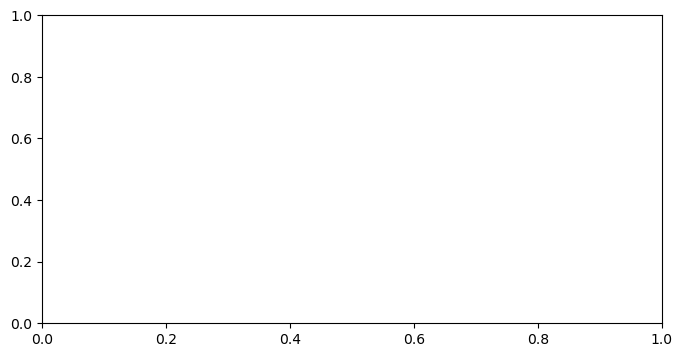

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
#save_fig("dqn_rewards_plot")
plt.show()

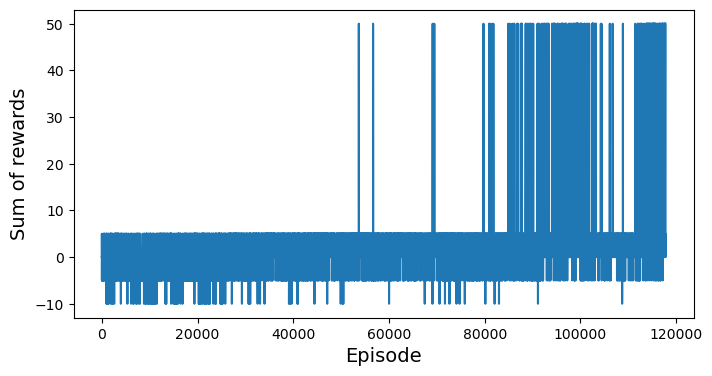

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(rewards_per_jugada)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
#save_fig("dqn_rewards_plot")
plt.show()

El mapa final:

In [ ]:
snowman_env.show_map(SnowmanEnvironment.ENCODED_TEXT_MODE)
snowman_env.show_map(SnowmanEnvironment.DECODED_TEXT_MODE)

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  9.  9.  9.  9.  9.  0.  0.]
 [ 0.  0.  9.  8.  8.  8.  8.  0.  0.]
 [ 0.  0.  9.  8.  7.  8.  8.  0.  0.]
 [ 0.  0.  9.  8. 11.  8.  8.  0.  0.]
 [ 0.  0.  8.  8.  8.  9.  9.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[['#' '#' '#' '#' '#' '#' '#' '#' '#']
 ['#' '#' '#' '#' '#' '#' '#' '#' '#']
 ['#' '#' '.' '.' '.' '.' '.' '#' '#']
 ['#' '#' '.' ',' ',' ',' ',' '#' '#']
 ['#' '#' '.' ',' '7' ',' ',' '#' '#']
 ['#' '#' '.' ',' 'q' ',' ',' '#' '#']
 ['#' '#' ',' ',' ',' '.' '.' '#' '#']
 ['#' '#' '#' '#' '#' '#' '#' '#' '#']
 ['#' '#' '#' '#' '#' '#' '#' '#' '#']]


Guardem el model:

In [ ]:
torch.save(training_agent.policy_net.state_dict(),save_path)

Carreguem el model i inferim:

In [ ]:

inferenceEnvironment = SnowmanEnvironment(map_path, map_rows, map_cols, preprocess_mode=SnowmanEnvironment.NO_PREPROCESS)
inferenceModel = DQN(inferenceEnvironment.layers,n_actions, map_rows, map_cols).to(device)
inferenceModel.load_state_dict(torch.load(save_path))
inferenceModel.eval()
done = False
max_steps = 100
steps = 0
while(not done and steps < max_steps):
    state = inferenceEnvironment.preprocess_map(inferenceEnvironment.map)
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    valid_actions, invalid_actions = inferenceEnvironment.get_valid_actions()
    actions = inferenceModel(state)
    invalid_actions = torch.tensor(invalid_actions, device=device, dtype=torch.long)
    actions[0,invalid_actions]=-100000    
    action = actions.max(1).indices.view(1, 1)
    _, _, done, _ = inferenceEnvironment.step(action)
    inferenceEnvironment.show_map(SnowmanEnvironment.DECODED_TEXT_MODE)
    print('\n')
    time.sleep(1)



n,m:  9 9
setting agent position to  4 4


RuntimeError: Error(s) in loading state_dict for DQN:
	size mismatch for linear1.weight: copying a param with shape torch.Size([256, 81]) from checkpoint, the shape in current model is torch.Size([256, 324]).

In [ ]:

from environments.SnowmanEnvironment import SnowmanEnvironment
snowman_env_test = SnowmanEnvironment(map_file='./Dades/test.txt', 
                                 n=9, m=12,
                                 preprocess_mode=SnowmanEnvironment.PREPROCESS_V2,
                                 enable_step_back_optimzation=True, 
                                 enable_blocked_snowman_optimization=True)
print(snowman_env_test.agent_position)
snowman_env_test.randomize_agent_position()
snowman_env_test.show_map(SnowmanEnvironment.DECODED_TEXT_MODE)
print()
print(snowman_env_test.split_map_layersV2(snowman_env_test.map)[1,:])
print()
print(snowman_env_test.split_map_layersV2(snowman_env_test.map)[2,:])
#snowman_env_test.previous_agent_position = (2,6)
#snowman_env_test.agent_position = (2,6)
#a = snowman_env_test.adjust_reward(0,[5,4],[4,4])
#print(snowman_env_test.agent_position)
#print("****************************************************************")
#snowman_env_test.step(3)
#snowman_env_test.show_map(SnowmanEnvironment.DECODED_TEXT_MODE)




n,m:  9 12
setting agent position to  6 2
(6, 2)
[['#' '#' '#' '#' '#' '#' '#' '#' '#' '#' '#' '#']
 ['#' '#' '#' '#' '#' '#' '#' '#' '#' '#' '#' '#']
 ['#' '#' '4' '.' '.' '.' '.' '#' '.' '.' '#' '#']
 ['#' '#' '.' '.' '.' '.' '.' '1' '.' 'p' '#' '#']
 ['#' '#' '.' '2' '.' '.' '.' '#' '.' '.' '#' '#']
 ['#' '#' '.' '.' '.' '.' '.' '#' '.' '.' '#' '#']
 ['#' '#' '.' '.' '.' '.' '1' '#' '.' '.' '#' '#']
 ['#' '#' '#' '#' '#' '#' '#' '#' '#' '#' '#' '#']
 ['#' '#' '#' '#' '#' '#' '#' '#' '#' '#' '#' '#']]

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 